# Google Earth Engine (GEE) tutorial

Author: Songyan.Zhu@soton.ac.uk | University of Southampton, UK

License: CC BY-NC

This tutorial will cover the use of GEE Python API to fetch and download data

It will use two Python modules:
- scigee (SCIentific GEE) [link](https://github.com/soonyenju/scitbx)
- scitbx (SCIentific TooBoX) [link](https://github.com/soonyenju/scigee)
- scigeo (SCIentific GEOspatial) [link](https://github.com/soonyenju/scigeo)
- sciml (SCIentific Machine Learning) [link](https://github.com/soonyenju/sciml)



# 1. Preparations

- `easy_import` imports key Python scientific computing & plotting modules -- like `numpy`, `matplotlib`, `scipy`, geospatial data processing modules -- like `rasterio`, `geopandas`, and `xarray`.

    - No worries if you haven't installed these modules, `easy_import` will download & install the missing ones automatically
    - `scitbx` also includes functions dealing with ecology like bigleaf model, photosynthesis, and evaportranspirations.

- `stutil` includes utility functions like round up decimals.
- `google` handles APIs like Google Drive.
- `remotesensing` includes common functions for remote sensing like calculating NDVI
- `geelite` wraps GEE APIs to facilitate smooth and easy process
- `geobox` deals with rasters, geometries, projections etc and includes wrappers for `GDAL`.

## 1.1 Install the modules

In [ ]:
!pip install scitbx --quiet
!pip install scigee --quiet
!pip install scigeo --quiet
!pip install sciml --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 42.5 MB/s eta 0:00:00


## 1.2 Import the modules

In [ ]:
from scitbx.easy_import import *
from scitbx.stutils import *
from scitbx.sciplt import *
from scitbx import google, remotesensing
from scigee import geelite
from scigeo import geobox

No module named 'rioxarray'


## 1.3.1 Set up the project root directory, mounting on Google Drive

Create the directory if it doesn't exist.

In [ ]:
root = google.mount_drive()
root_proj = root.joinpath('temp/project_101')
root_proj.mkdir(parents = True, exist_ok = True)

Mounted at /content/drive


## 1.3.2 Set up the project root directory, on temporary disk provided by Colab

Create the directory if it doesn't exist.

In [ ]:
root_temp = Path('/content')
root_temp_proj = root_temp.joinpath('project_101')
root_temp_proj.mkdir(parents = True, exist_ok = True)

## 1.4 Initialise GEE API

It goes as
```
geelite.init_gee('<your-credentials>')
```
*REMEMBER TO USE YOUR OWN CREDENTIALS*

In [ ]:
from scigee import *
geelite.init_gee('ee-zhusy93')

# GEE how-to

For example, [MODIS Nadir BRDF-Adjusted Reflectance Daily 500m MCD43A4.061] (https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MCD43A4)
<!-- [Sentinel-2 L2A surface reflectance](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED) -->

GEE includes three geospatial data types:
- image -- satellite imagery,
- collection -- a set of images,
- features -- geometries like points and polygons

## Meta information

First, get the UK shapefile from my GitHub

<Axes: >

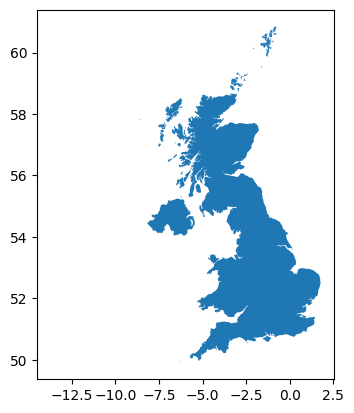

In [ ]:
world = gpd.read_file((r'https://github.com/soonyenju/scitbx/blob/master/scitbx/data/WB_countries_Admin0_10m.json?raw=true'))
soton = gpd.read_file((r'https://github.com/soonyenju/scitbx/blob/master/scitbx/data/Southampton.json?raw=true'))
UK = world[world['NAME_EN'] == 'United Kingdom']
UK = UK[['geometry']].dissolve()
UK.plot()

Second, get the bounds of UK as a rectangle

In [ ]:
minlon_ = UK.bounds.minx.values[0]
maxlon_ = UK.bounds.maxx.values[0]
minlat_ = UK.bounds.miny.values[0]
maxlat_ = UK.bounds.maxx.values[0]

roi = ee.Geometry.BBox(minlon_, minlat_, maxlon_, maxlat_)

minlon_soton = soton.bounds.minx.values[0]
maxlon_soton = soton.bounds.maxx.values[0]
minlat_soton = soton.bounds.miny.values[0]
maxlat_soton = soton.bounds.maxx.values[0]

roi_soton = ee.Geometry.BBox(minlon_soton, minlat_soton, maxlon_soton, maxlat_soton)

Then, set the collection name dataset like MODIS and the date range you like

In [ ]:
collection_name = 'MODIS/061/MCD43A4' # 'COPERNICUS/S2_SR_HARMONIZED'
date_range = ['2022-01-01', '2022-12-31']
collection = geelite.filter_collection(collection_name, date_range, roi)
collection

Now, how many images in the fetched collection?

In [ ]:
geelite.get_collection_size(collection)

364

Let's have a look at the first image, what bands does it have:

In [ ]:
image = geelite.get_image(collection, 0)
bandnames = geelite.get_image_bandnames(image)
print(bandnames)

['Nadir_Reflectance_Band1', 'Nadir_Reflectance_Band2', 'Nadir_Reflectance_Band3', 'Nadir_Reflectance_Band4', 'Nadir_Reflectance_Band5', 'Nadir_Reflectance_Band6', 'Nadir_Reflectance_Band7', 'BRDF_Albedo_Band_Mandatory_Quality_Band1', 'BRDF_Albedo_Band_Mandatory_Quality_Band2', 'BRDF_Albedo_Band_Mandatory_Quality_Band3', 'BRDF_Albedo_Band_Mandatory_Quality_Band4', 'BRDF_Albedo_Band_Mandatory_Quality_Band5', 'BRDF_Albedo_Band_Mandatory_Quality_Band6', 'BRDF_Albedo_Band_Mandatory_Quality_Band7']


What's the projection of the first band ?

In [ ]:
proj = geelite.get_proj(image, bandnames[0], True)
print(proj)

{'type': 'Projection', 'crs': 'SR-ORG:6974', 'transform': [463.3127165279165, 0, -20015109.354, 0, -463.3127165279167, 7783653.637669001]}


What's the spatial resolution and date of image accquired?

In [ ]:
print(geelite.get_scale(image), geelite.get_date(image))

463.31271652791656 2022-1-1 00:00:00.0000


## Go geospatial!

Let's have a look at the NDVI in Southampton!

In [ ]:
collection = (
    ee.ImageCollection('MODIS/061/MCD43A4')
    .filterBounds(roi_soton)
    .filterDate('2022-01-01', '2022-03-31')
)
# modis = collection.select(['Nadir_Reflectance_Band1', 'Nadir_Reflectance_Band2']).first()  # Get first image
# ------------------------------------------------------------------------------------------------------------------------
# collection_list = collection.toList(collection.size())
# modis = ee.Image(collection_list.get(1)).select(['Nadir_Reflectance_Band1', 'Nadir_Reflectance_Band2']) # Get second image
# ------------------------------------------------------------------------------------------------------------------------
modis = collection.select(['Nadir_Reflectance_Band1', 'Nadir_Reflectance_Band2']).reduce(ee.Reducer.mean()) # Average image
modis = modis.rename('Nadir_Reflectance_Band1', 'Nadir_Reflectance_Band2')
modis = modis.reproject(crs = "EPSG:4326", scale = 500)

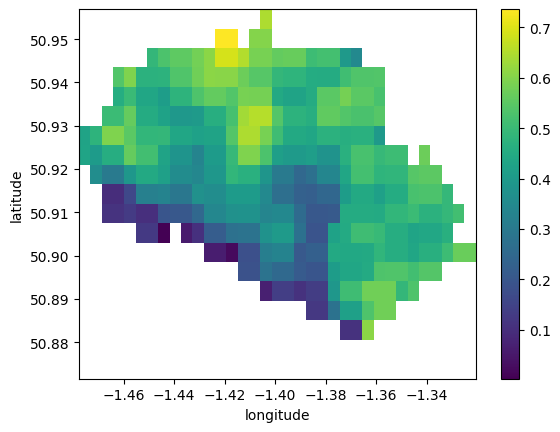

In [ ]:
sr = geelite.image4shape(modis, soton, 500, to_xarray = True)
ndvi = remotesensing.get_NDVI(sr['Nadir_Reflectance_Band1'], sr['Nadir_Reflectance_Band2'])
ndvi = ndvi.where(ndvi >= 0, np.nan)
ndvi.plot()

## Time series

What if I want to have time series of like MODIS LAI for a FLUXNET site?

Load in the meta information from my GitHub

In [ ]:
meta = pd.read_csv((r'https://github.com/soonyenju/scitbx/blob/master/scitbx/data/fluxnet_meta_212.csv?raw=true'),index_col = 0)

In [ ]:
meta

,IGBP,LAT,LON,START,END,IRGA,SA,INST_H,CANOPY_H,KOPPEN,ELEV,PLANT,COUNTRY,LAND,SYSTEMS,HEIGHT_R,TIER
ID,,,,,,,,,,,,,,,,,
AR-SLu,MF,-33.464800,-66.459800,2009-01-01 00:00:00,2011-12-31 23:30:00,LI-7500,CSAT-3,9.0,4.50,BSh - Arid Steppe hot,505,NaN,Argentina,South America,O,2.000000,1
AR-Vir,ENF,-28.239500,-56.188600,2009-01-01 00:00:00,2012-12-31 23:30:00,LI-7500,CSAT3,18.0,12.00,Cfa - Warm temperate fully humid with hot summer,105,NaN,Argentina,South America,O,1.500000,1
AT-Neu,GRA,47.116670,11.317500,2002-01-01 00:00:00,2012-12-31 23:30:00,LI-6262,R3IA,3.0,0.76,Dfc - Snow fully humid cool summer,1095,Evergreen Broadleaf Trees,Austria,Europe,C,3.947368,1
AU-Ade,WSA,-13.076900,131.117800,2007-01-01 00:00:00,2009-12-31 23:30:00,LI-7500,CSAT3,16.5,12.50,Aw - Equatorial savannah with dry winter,76,Grass,Australia,Australia/Oceania,O,1.320000,1
AU-ASM,ENF,-22.283000,133.249000,2010-01-01 00:00:00,2014-12-31 23:30:00,LI-7500,CSAT3,11.7,6.50,BSh - Arid Steppe hot,606,Shrub,Australia,Australia/Oceania,O,1.800000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
US-Wi9,ENF,46.618778,-91.081444,2004-01-01 00:00:00,2005-12-31 23:30:00,LI-7500,CSAT-3,9.0,2.40,Dfb - Snow fully humid warm summer,347,Evergreen Needleleaf Trees,United States,North America,O,3.750000,1
US-Wkg,GRA,31.736500,-109.941900,2004-01-01 00:00:00,2014-12-31 23:30:00,LI-7500,CSAT-3,6.4,0.50,BSk - Arid Steppe cold,1524,Grass,United States,North America,O,12.800000,1
US-WPT,WET,41.464639,-82.996157,2011-01-01 00:00:00,2013-12-31 23:30:00,LI-7500,CSAT-3,2.7,0.60,Dfa - Snow with fully humid hot summer,175,Deciduous Broadleaf Trees,United States,North America,O,4.500000,1


Let's see LAI for site BE-Bra

In [ ]:
lon_ = meta.loc['BE-Bra', 'LON']
lat_ = meta.loc['BE-Bra', 'LAT']

Where is it?
Use `sciplt` to have a look

(35.0, 70.0)

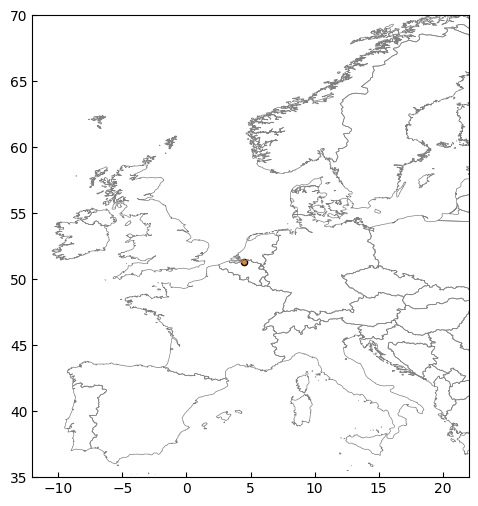

In [ ]:
Europe = world[world['CONTINENT'] == 'Europe']

fig, ax = setup_canvas(1, 1, figsize = (8, 6), fontsize = 10, labelsize = 10)
ax.scatter(lon_, lat_, s = 20, color = colors[1], edgecolors = 'k')
Europe.plot(ax = ax, facecolor = 'none', edgecolor = 'gray', linewidth = 0.5)
ax.set_xlim(-12, 22)
ax.set_ylim(35, 70)

Use `scigee` to get the time series

Text(0, 0.5, 'LAI (m2/m2)')

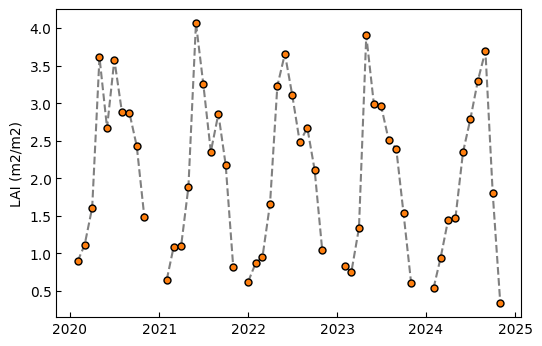

In [ ]:
def apply_qc(image):
    qc = image.select("FparLai_QC")

    # Apply bitmask: Keep pixels where (Bits 0-1 == 0) and (Bit 6 == 0)
    mask = qc.bitwiseAnd(3).eq(0).And(qc.bitwiseAnd(64).eq(0))

    # Mask bad-quality pixels
    return image.select("Lai").updateMask(mask)

collection = ee.ImageCollection('MODIS/061/MCD15A3H').map(apply_qc)
lai = geelite.collection2ts(collection, [lat_, lon_], ['2020-01-01', '2025-01-01'], ['Lai'], 500) / 10
lai = lai.resample('1MS').mean()

fig, ax = setup_canvas(1, 1, figsize = (6, 4), fontsize = 10, labelsize = 10)
ax.plot(lai.index, lai['Lai'], linestyle='--', marker='o', color = 'gray', markersize = 5, markerfacecolor = colors[1], markeredgecolor='black')
ax.set_ylabel('LAI (m2/m2)')

What if I want to have a look of averged LAI of all ICOS?

In [ ]:
# Europe small
minlon_ = -12
maxlon_ = 20
minlat_ = 35
maxlat_ = 60

roi_eu = ee.Geometry.BBox(minlon_, minlat_, maxlon_, maxlat_)

In [ ]:
meta = pd.read_csv((r'https://github.com/soonyenju/scitbx/blob/master/scitbx/data/ICOS_meta.csv?raw=true'),index_col = 0)
meta.loc['SJ-Blv', 'Site Name'] = 'Bayelva Spitsbergen'
meta.loc['SJ-Blv', 'Site Responsible'] = 'Julia Boike'
meta.loc['SJ-Blv', 'Site Latitude'] = '78.921631'
meta.loc['SJ-Blv', 'Site Longitude'] = '11.83108521'
meta.loc['SJ-Blv', 'Site Name'] = 'SNO'

meta['Site Latitude'] = meta['Site Latitude'].astype(float)
meta['Site Longitude'] = meta['Site Longitude'].astype(float)

meta = meta.rename(columns = {'Site Latitude': 'LAT', 'Site Longitude': 'LON', 'IGBP Cde': 'IGBP'})

meta = meta.rename(columns = {'LAT': 'latitude', 'LON': 'longitude'})

<ipython-input-21-cff37d54afa6>:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '11.83108521' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  meta.loc['SJ-Blv', 'Site Longitude'] = '11.83108521'


In [ ]:
collection = ee.ImageCollection('MODIS/061/MCD15A3H').filterDate('2022-06-01', '2022-08-31').filterBounds(roi_eu).map(apply_qc)
modis_lai = collection.select(['Lai']).reduce(ee.Reducer.mean()) # Average image
modis_lai = modis_lai.rename('Lai')
# modis_lai = modis_lai.reproject(crs = "EPSG:4326", scale = 500)

In [ ]:
# dfi = meta[['IGBP', 'LAT', 'LON']].rename(columns = {'LAT': 'latitude', 'LON': 'longitude'})
dfi = meta[['latitude', 'longitude']]
df_lai = geelite.image2points(modis_lai, dfi, 5000, longitude = 'longitude', latitude = 'latitude', batch_size = 100)
df_lai['Lai'] /= 10
df_lai

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
iterating batches...: 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]


,Lai,Site Code,latitude,longitude
0,3.057143,AT-Fue,47.367374,11.854709
0,2.018182,AT-Hnb,47.803333,13.591389
0,3.572222,AT-Inn,47.264096,11.385816
0,2.077778,AT-Lan,47.061221,10.963454
0,3.166667,AT-Leu,47.378036,11.16278
...,...,...,...,...
0,2.109091,UK-Tad,51.2071,-2.82864
0,0.82,ZA-Kru,-25.0197,31.4969
0,0.733333,ZA-Map,-23.83254,31.21436
0,0.278571,ZA-Wgn,-26.569444,26.939167


(35.0, 70.0)

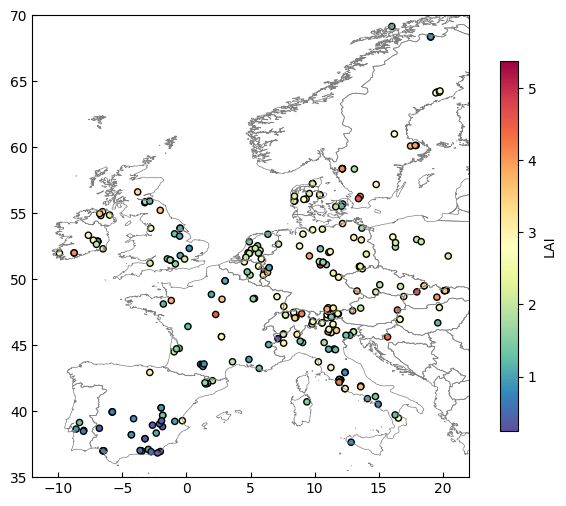

In [ ]:
Europe = world[world['CONTINENT'] == 'Europe']

fig, ax = setup_canvas(1, 1, figsize = (8, 6), fontsize = 10, labelsize = 10)
sc = ax.scatter(df_lai['longitude'], df_lai['latitude'], s = 20, c = df_lai['Lai'], edgecolors = 'k', cmap = 'Spectral_r')
cbar = fig.colorbar(sc, ax=ax, orientation='vertical', shrink = 0.8, label='LAI')
Europe.plot(ax = ax, facecolor = 'none', edgecolor = 'gray', linewidth = 0.5)
ax.set_xlim(-12, 22)
ax.set_ylim(35, 70)

# Comparisons

In [48]:
df = pd.read_csv('BE-Bra_data_retrieved.csv', index_col = 0)
df.index = pd.to_datetime(df.index, format = '%Y/%m/%d')

df['MODIS_Nadir_Reflectance_Band1'] = df['MODIS_Nadir_Reflectance_Band1'] / 1e4
df['MODIS_Nadir_Reflectance_Band2'] = df['MODIS_Nadir_Reflectance_Band2'] / 1e4

df = df[['VIIRS_M5', 'VIIRS_M7', 'MODIS_Nadir_Reflectance_Band1', 'MODIS_Nadir_Reflectance_Band2']]

In [57]:
meta.loc['BE-Bra', :]

,BE-Bra
Site Name,Brasschaat
Site Responsible,Ivan Janssens| EFDC Staff
latitude,51.30761
longitude,4.51984
IGBP,MF


In [58]:
lat_ = 51.30761
lon_ = 4.51984

collection = ee.ImageCollection('NASA/VIIRS/002/VNP09GA')
viirs = geelite.collection2ts(collection, [lat_, lon_], ['2018-01-01', '2022-01-01'], ['M4', 'M5', 'M7'], 1000)

In [59]:
collection = ee.ImageCollection('MODIS/061/MCD43A4')
modis = geelite.collection2ts(collection, [lat_, lon_], ['2018-01-01', '2022-01-01'], ['Nadir_Reflectance_Band1', 'Nadir_Reflectance_Band2'], 500)

In [85]:
collection = ee.ImageCollection('COPERNICUS/S3/OLCI')
s3 = geelite.collection2ts(collection, [lat_, lon_], ['2020-01-01', '2022-01-01'], [
    'Oa08_radiance', 'Oa09_radiance', 'Oa10_radiance',
    'Oa11_radiance', 'Oa12_radiance', 'Oa17_radiance', 'Oa18_radiance'
    ], 500)

s3 = s3.resample('1D').mean()
s3['Oa08_radiance'] = s3['Oa08_radiance'] * 0.00876539
s3['Oa09_radiance'] = s3['Oa09_radiance'] * 0.0095103
s3['Oa10_radiance'] = s3['Oa10_radiance'] * 0.00773378
s3['Oa11_radiance'] = s3['Oa11_radiance'] * 0.00675523
s3['Oa12_radiance'] = s3['Oa12_radiance'] * 0.0071996
s3['Oa17_radiance'] = s3['Oa17_radiance'] * 0.00493004
s3['Oa18_radiance'] = s3['Oa18_radiance'] * 0.00549962
s3 = s3[s3 > 0]

In [60]:
collection = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_CLOUD')
cloud = geelite.collection2ts(collection, [lat_, lon_], ['2018-01-01', '2022-01-01'], ['cloud_fraction'], 500)

In [113]:
df = pd.concat([cloud.resample('1D').mean(), viirs, modis, s3], axis = 1).dropna()
df = df[df['cloud_fraction'] < 0.2]
df['Nadir_Reflectance_Band1'] /= 1e4
df['Nadir_Reflectance_Band2'] /= 1e4

# df['Oa10_radiance'] = df['Oa10_radiance'] / 100

LinregressResult(slope=3.086341880607582, intercept=0.10733237609059373, rvalue=0.0885611744332726, pvalue=0.3959850724469175, stderr=3.619069587284825, intercept_stderr=0.16647772317005166)

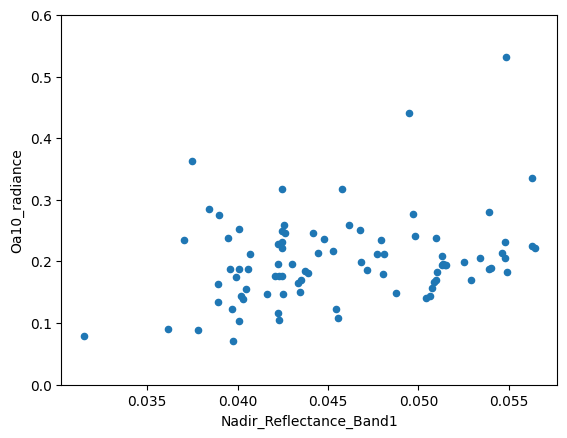

In [115]:
df.plot.scatter(x = 'Nadir_Reflectance_Band1', y = 'Oa10_radiance', ylim = (0, 0.6))
stats.linregress(df['Nadir_Reflectance_Band1'], df['Oa10_radiance'])

In [125]:
df = pd.read_csv((r'https://github.com/soonyenju/scitbx/blob/master/scitbx/data/Ameriflux_meta.csv?raw=true'),index_col = 0)

In [131]:
df.index.map(lambda x: x if x.startswith('CA') else np.nan).dropna()

Index(['CA-AF1', 'CA-ARB', 'CA-ARF', 'CA-BCW', 'CA-BOU', 'CA-Ca1', 'CA-Ca2',
       'CA-Ca3', 'CA-Cbo', 'CA-CF1', 'CA-CF2', 'CA-CF3', 'CA-Cha', 'CA-CQ1',
       'CA-DB2', 'CA-DBB', 'CA-DL1', 'CA-DL2', 'CA-DSM', 'CA-EM1', 'CA-EM2',
       'CA-EM3', 'CA-ER1', 'CA-ER2', 'CA-Gro', 'CA-HPC', 'CA-KLP', 'CA-Let',
       'CA-LP1', 'CA-LuM', 'CA-MA1', 'CA-MA2', 'CA-MA3', 'CA-Man', 'CA-Mer',
       'CA-MR3', 'CA-MR5', 'CA-Mtk', 'CA-Na1', 'CA-NS1', 'CA-NS2', 'CA-NS3',
       'CA-NS4', 'CA-NS5', 'CA-NS6', 'CA-NS7', 'CA-NS8', 'CA-Oas', 'CA-Obs',
       'CA-Ojp', 'CA-Qc2', 'CA-Qcu', 'CA-Qfo', 'CA-RBM', 'CA-RPn', 'CA-RPp',
       'CA-RSB', 'CA-SCB', 'CA-SCC', 'CA-SF1', 'CA-SF2', 'CA-SF3', 'CA-SJ1',
       'CA-SJ2', 'CA-SJ3', 'CA-SMC', 'CA-TP1', 'CA-TP2', 'CA-TP3', 'CA-TP4',
       'CA-TPA', 'CA-TPD', 'CA-TVC', 'CA-WP1', 'CA-WP2', 'CA-WP3', 'CA-WRF'],
      dtype='object', name='Site ID')

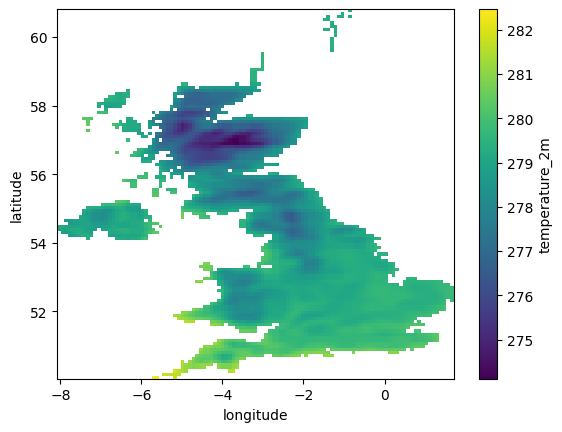

In [148]:
collection = (
    ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')
    .filterBounds(roi)
    .filterDate('2022-01-01', '2022-03-31')
)
# ------------------------------------------------------------------------------------------------------------------------
era5 = collection.select(['temperature_2m']).reduce(ee.Reducer.mean()) # Average image
era5 = era5.rename('temperature_2m')
era5 = era5.reproject(crs = "EPSG:4326", scale = 0.1 * 1e5)
# ------------------------------------------------------------------------------------------------------------------------
nc_era5 = geelite.image4shape(era5, UK, 0.1 * 1e5, to_xarray = True)
nc_era5['temperature_2m'].plot()